# 중고차 판매 데이터 전처리
### 사용 라이브러리

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# VIN API 호출용 라이브러리
import requests, json
import io

# Dask 라이브러리 불러오기
import dask
from dask import delayed
import dask.dataframe as dd
from dask.distributed import Client, progress

### 데이터 불러오기

In [2]:
# 데이터 불러오기
raw_vehicle_data = pd.read_parquet('./data/raw_vehicle_data.parquet', engine='pyarrow')
raw_vehicle_data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

### 필요없는 컬럼들 제거
ID, url, region_url, image_url과 같이 사용하지 않을 컬럼들은 미리 제거해 주겠습니다.

*(county 컬럼은 데이터 설명 자체에도 실수로 포함된 컬럼을 표기되어 있기 떄문에 같이 제거해 주겠습니다)*

In [3]:
raw_vehicle_data.drop(['id', 'url', 'region_url', 'image_url', 'county'], axis=1, inplace=True)

### 컬럼별 결측치 개수 파악

In [4]:
# 집계함수 적용
info = raw_vehicle_data.agg(['nunique', 'count', 'size']).T

# 결측치 및 결측치 비율 계산
info['null'] = raw_vehicle_data.isnull().sum()
info['null_ratio'] = info['null'] / info['size']
info['dtype'] = raw_vehicle_data.dtypes
info

,nunique,count,size,null,null_ratio,dtype
region,404,426880,426880,0,0.000000,object
price,15655,426880,426880,0,0.000000,int64
year,114,425675,426880,1205,0.002823,float64
manufacturer,42,409234,426880,17646,0.041337,object
model,29667,421603,426880,5277,0.012362,object
condition,6,252776,426880,174104,0.407852,object
cylinders,8,249202,426880,177678,0.416225,object
fuel,5,423867,426880,3013,0.007058,object
odometer,104870,422480,426880,4400,0.010307,float64
title_status,6,418638,426880,8242,0.019308,object


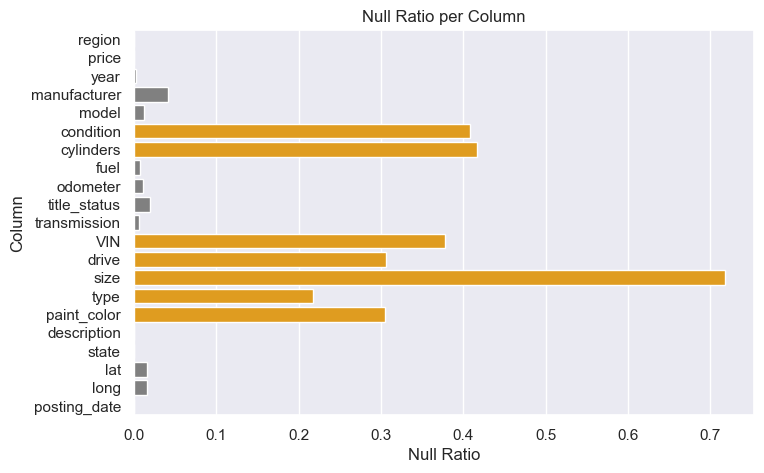

In [5]:
# 컬럼별 결측치 비율 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=info['null_ratio'], y=info.index,
            hue = np.where(info['null_ratio'] > 0.2, 'High', 'Low'),
            palette=['gray', 'orange'])

plt.ylabel('Column')
plt.xlabel('Null Ratio')
plt.title('Null Ratio per Column')
plt.legend([],[], frameon=False)
plt.show()

주황색으로 표기된 컬럼들은 결측치 비율이 20%가 넘는 컬럼들입니다.

결측치 비율이 낮다면 단순히 결측치를 포함한 열을 제거하는 것도 방법이지만, \
이렇게 높은 결측치 비율을 가진 컬럼들은 결측치를 채워주거나 컬럼 자체를 사용하지 않아야 합니다.

---
## 컬럼별 데이터 전처리
각각의 컬럼들을 분석하면서 데이터의 품질을 좀 더 상향시켜 보겠습니다.

In [6]:
# 새로운 데이터프레임 생성
vehicle_data = raw_vehicle_data.copy()

### 1. 가격 (Price)
판매자가 제시한 금액을 의미합니다.

머신러닝 모델을 이용해 예측하게 될 **종속변수**입니다.

In [7]:
# 컬럼 정보 확인
info.loc[['price'], ['null', 'null_ratio', 'dtype']]

,null,null_ratio,dtype
price,0,0.0,int64


Price 컬럼은 결측치가 없으며 데이터 타입도 이미 올바른 int64입니다.

In [8]:
# Price 컬럼의 범위 확인
vehicle_data['price'].agg(['min', 'max'])

min             0
max    3736928711
Name: price, dtype: int64

최저값은 $0, 최대값은 $3.7억이 넘습니다. 비록 가격은 제시하는 판매자 마음이지만,\
너무 작거나 커서 황당한 값은 이상치로 분류해서 제거해 주도록 하겠습니다.

$100 미만이거나 $1백만 이상의 가격은 중고차 판매가로서 터무니 없는 가격이라 생각하여 이상치로 분류하고 제외시키겠습니다

In [9]:
# 이상치 확인
too_small = vehicle_data['price'] < 100
too_large = vehicle_data['price'] > 1000000

print(f"값이 $100 미만인 샘플 개수: {vehicle_data[too_small].shape[0]}개, 비율: {vehicle_data[too_small].shape[0] / vehicle_data.shape[0]:.2%}")
print(f"값이 $1백만 이상인 샘플 개수: {vehicle_data[too_large].shape[0]}개, 비율: {vehicle_data[too_large].shape[0] / vehicle_data.shape[0]:.2%}")

값이 $100 미만인 샘플 개수: 36222개, 비율: 8.49%
값이 $1백만 이상인 샘플 개수: 53개, 비율: 0.01%


In [10]:
# 가격이 100달러 미만, 100만달러 초과 데이터 제거
vehicle_data = vehicle_data[~too_small & ~too_large]

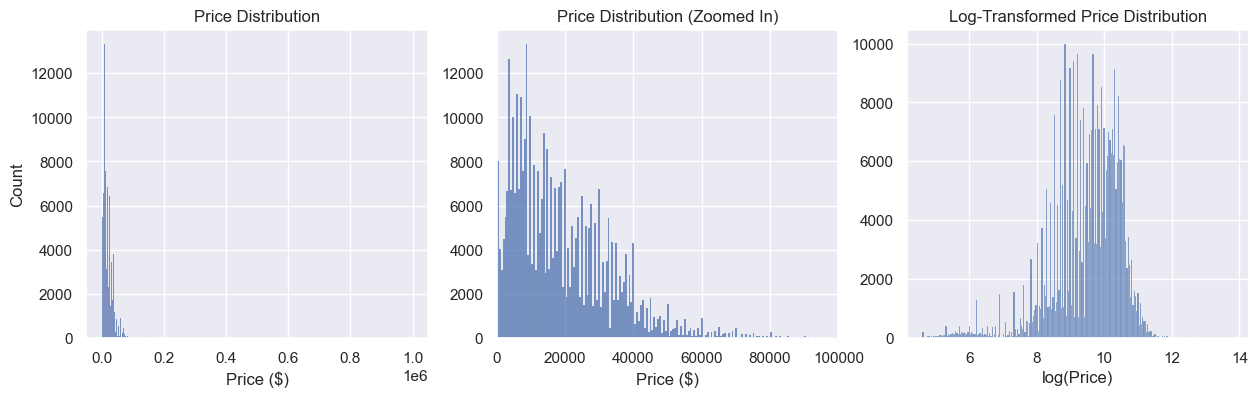

In [11]:
# 이상치를 제거한 Price 컬럼 분포도 시각화
fig, axis = plt.subplots(1, 3, figsize=(15, 4))

# histplot 그리기
sns.histplot(vehicle_data['price'], ax=axis[0])
axis[0].set_title('Price Distribution')
axis[0].set_xlabel('Price ($)')

# x축의 범위를 지정하여 histplot 그리기
sns.histplot(vehicle_data['price'], ax=axis[1])
axis[1].set_title('Price Distribution (Zoomed In)')
axis[1].set_xlabel('Price ($)')
axis[1].set_xlim(0, 100000)
axis[1].set_ylabel('')

# np.log1p() 함수로 로그 변환
sns.histplot(np.log1p(vehicle_data['price']), ax=axis[2])
axis[2].set_title('Log-Transformed Price Distribution')
axis[2].set_xlabel('log(Price)')
axis[2].set_ylabel('')

plt.show()

Price의 범위가 너무 넓어 분포를 자세히 보기 어렵기에 범위를 좁혀 다시 시각화 했습니다.

분포가 lognormal 분포의 모습을 띄고 있어 log(Price)도 시각화 해주었습니다.

* 특정 값들의 빈도 수가 전체적인 분포의 모습과 맞지 않게 높은 것을 볼 수 있는데,\
이는 사람들이 가격 제시를 할때, 5, 10, 100, 500등 단위로 맞춰 제시하기 때문입니다.

In [12]:
# 빈도가 가장 높은 20개의 가격 출력
vehicle_data['price'].value_counts().head(20).index

Index([ 6995,  7995,  9995,  8995,  4500,  5995,  3500, 29990,  6500,  5500,
       10995,  7500, 25990, 27990,  2500,  4995, 26990, 11995, 12995, 14995],
      dtype='int64', name='price')

### 2. 생산 연도 (Year)
차량이 만들어진 생산 연도를 의미합니다. 좀 더 정확히 표기하기 위해 model_year라는 변수로 바꿔주겠습니다.

In [13]:
# 컬럼 정보 확인
info.loc[['year'], ['null', 'null_ratio', 'dtype']]

,null,null_ratio,dtype
year,1205,0.002823,float64


결측치는 <1%로 낮습니다. 연도 값은 무조건 정수 값이기 때문에 dtype을 바꿔주겠습니다.

In [14]:
# year 컬럼 타입을 int로 변환
vehicle_data['year'] = vehicle_data['year'].astype('Int64')

# 컬럼명 변경
vehicle_data.rename(columns={'year': 'model_year'}, inplace=True)

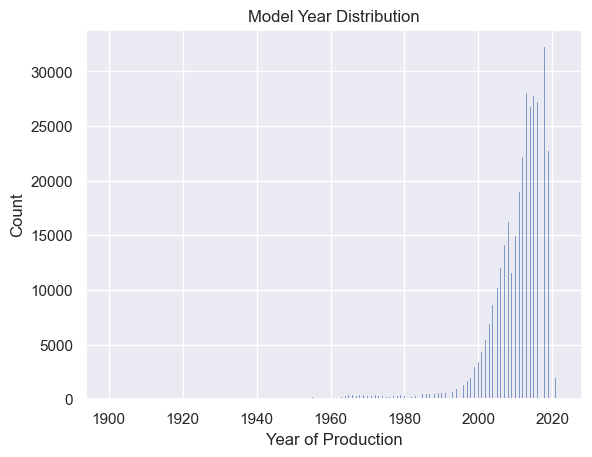

In [15]:
# model_year 컬럼 분포 시각화
sns.histplot(vehicle_data['model_year'])
plt.xlabel('Year of Production')
plt.title('Model Year Distribution')
plt.show()

선행연구: **이화여자대학교 대학원. (2019). 국산 중고 자동차 가격 예측 및 영향요인 분석. 조수진 석사학위 청구논문**에서

    "자동차는 오래 사용할 수록 가격이 낮아지지만, 일정 기간(약 15년)이 지나가면 희소가치에 의한 프리미엄으로 가격이 높아진다."

라고 서술한 바 있습니다. 이 데이터도 똑같은 현상으로 보여주는지 확인해 보겠습니다.

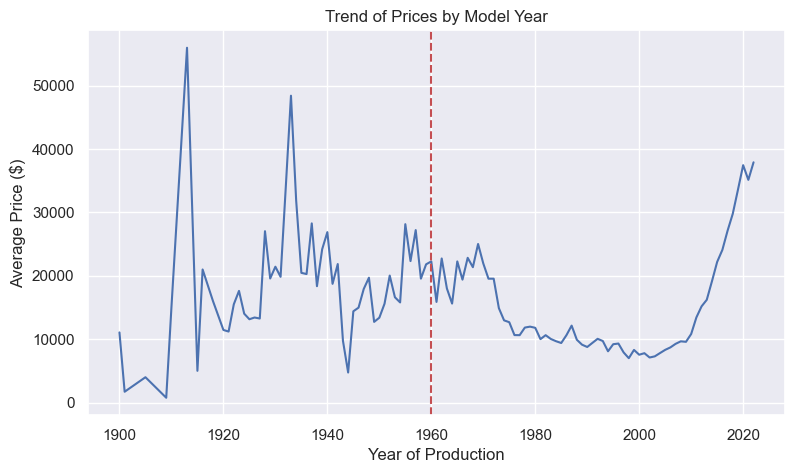

In [17]:
# 생산 연도별 평균 가격 계산
average_price_by_year = vehicle_data.groupby('model_year')['price'].mean().reset_index()

# 생산 연도별 가격 추이 시각화
plt.figure(figsize=(9, 5))

sns.lineplot(data=average_price_by_year, x='model_year', y='price')
plt.axvline(x=1960, color='r', linestyle='--')

plt.title('Trend of Prices by Model Year')
plt.xlabel('Year of Production')
plt.ylabel('Average Price ($)')

plt.show()

선행연구가 주장한 바와 동일하게, 2021년부터 2020년까지는 오래된 차일 수록 가격이 하락세를 보이다가, \
2000년 이전에 만들어진 차들은 연식에 비례해서 다시 가격이 상승하는 것을 볼 수 있습니다. 

1960년 이전 평균 가격은 훨씬 더 변동성이 심한 모습을 모이는데, 이는 샘플 수가 적기 때문입니다.

그러므로 1960년 이전 데이터는 제외하고 진행하도록 하겠습니다.

In [18]:
# model_year가 1960년 이전인 데이터 제거
vehicle_data = vehicle_data[vehicle_data['model_year'] >= 1960]

### 3. 차대번호 - VIN (Vehicle Identification Number)
VIN은 자동차 안전과 관련된 가장 핵심적인 세부정보를 포함합니다.

실제로 (차체에 직접 마킹되는) 이 식별번호는 제조공정 전반과 공장 출고 후 자동차 수명의 전반 모두에서 자동차의 이력을 확보하는데 도움이 됩니다.

https://www.vindecoderz.com/ 이미지

https://vpic.nhtsa.dot.gov/api/ API 사용

In [19]:
# VIN 결측치 개수 확인
print(f"결측치 개수: {vehicle_data['VIN'].isnull().sum()}개")
print(f"결측치 비율: {vehicle_data['VIN'].isnull().sum() / vehicle_data.shape[0] * 100:.2f}%")

결측치 개수: 148462개
결측치 비율: 38.35%


비록 결측치가 많고 차량 별로 다른 VIN을 가지고 있기 때문에 직접 모델에 피쳐로 사용되진 않을 것입니다.

그러나 VIN을 해석해서 얻는 정보들이 다른 컬럼의 데이터를 보완해 줄 수 있기 때문에 이 용도로 사용하겠습니다.

In [20]:
# VIN이 정보를 제공하는 컬럼들을 추출
category_list = ['VIN', 'manufacturer', 'model', 'cylinders', 'fuel', 'transmission', 'drive', 'type']

notnull_df = pd.DataFrame()

# 각 샘플별 해당 컬럼에 결측치가 있는지 여부를 저장
for category in category_list:
    notnull_df[f'has_{category}'] = vehicle_data[category].notnull()

# 데이터프레임 보기    
notnull_df.sample(5)

,has_VIN,has_manufacturer,has_model,has_cylinders,has_fuel,has_transmission,has_drive,has_type
51147,True,True,True,False,True,True,True,True
425781,False,True,True,False,True,True,False,False
373205,True,True,True,False,True,True,True,True
62172,True,True,True,True,True,True,True,True
65470,True,True,True,False,True,True,True,True


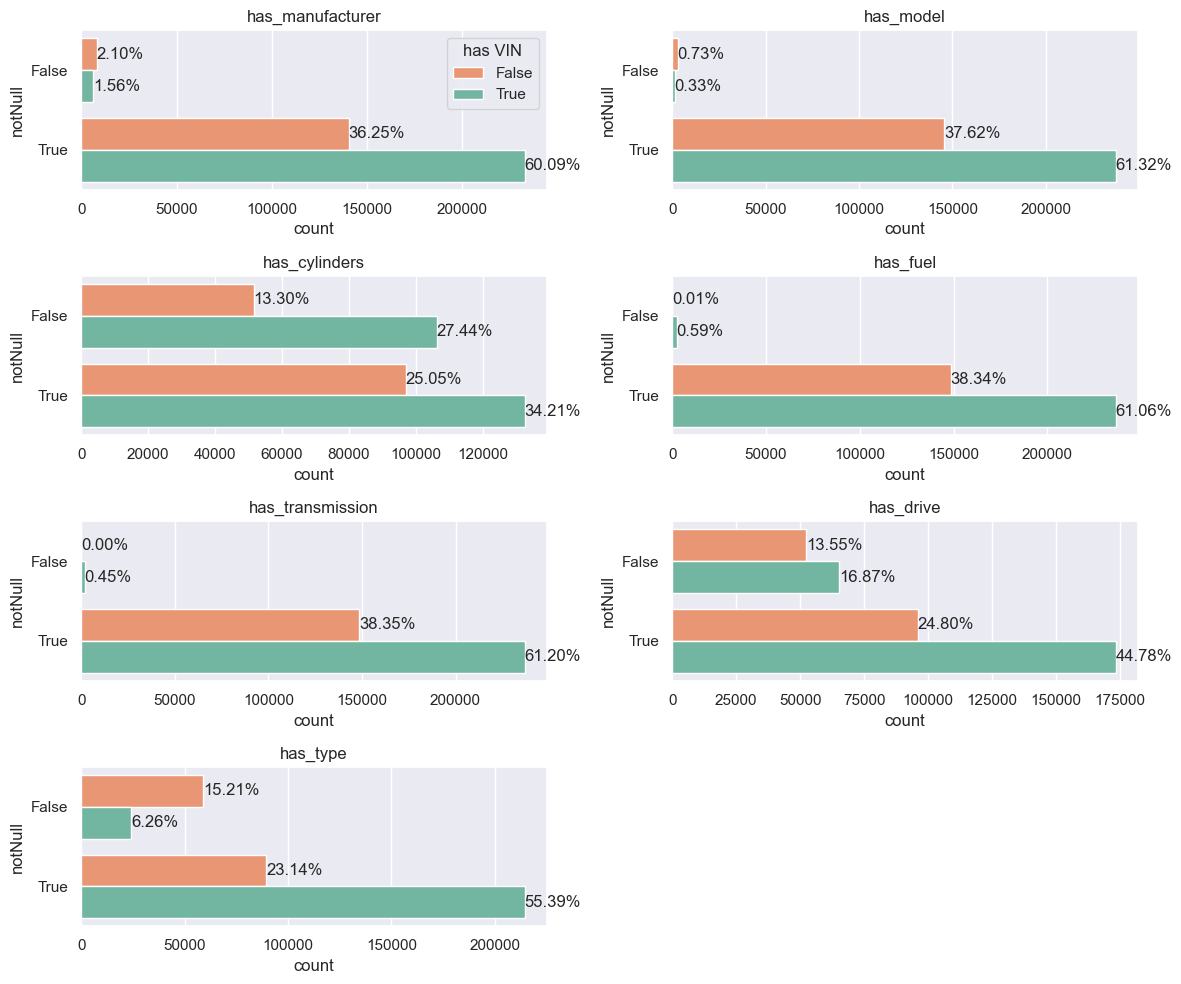

In [21]:
# notnull_df 빈도수 시각화
fig, axis = plt.subplots(4, 2, figsize=(12, 10))

for i, category in enumerate(notnull_df.columns[1:]):
    sns.countplot(y=category, data=notnull_df, ax=axis[i // 2, i % 2], hue='has_VIN', 
                  palette=sns.set_palette(['#fc8d62', '#66c2a5']))
    
    # 퍼센트 표시
    for j in range(2):
        for p in axis[i // 2, i % 2].patches[j:4:2]:
            width = p.get_width()
            axis[i // 2, i % 2].text(width + 5, p.get_y() + p.get_height() / 2, f'{width / notnull_df.shape[0] * 100:.2f}%', ha='left', va='center')
    
    # 범례 제거
    axis[i // 2, i % 2].get_legend().remove()
    
    # 제목 추가
    axis[i // 2, i % 2].set_title(category)
    axis[i // 2, i % 2].set_ylabel('notNull')
    axis[i // 2, i % 2].yaxis.label.set_rotation(90)

# 안쓰는 subplot 숨기기
axis[3, 1].axis('off')    

# 전체 범례 추가
axis[0, 0].legend(loc='upper right', title='has VIN')

plt.tight_layout()
plt.show()

위 도표에서 봤을때 위에서 두번쨰 컬럼이 의미하는 것이 해당 피쳐는 없지만 그 샘플에 대한 VIN은 보유하고 있는 행의 개수입니다.

이 그룹에 속해 있는 샘플들의 결측치는 VIN 정보를 조회하여 기존 자료에 있는 결측치를 보완할 수 있습니다.

#### VIN 디코딩 데이터 추출

In [22]:
# API 콜을 통해 VIN 번호를 디코딩하는 함수 정의
# 많은 양의 데이터를 처리하기 때문에 @delayed 데코레이터를 사용하여 지연된 함수로 만듦
@delayed
def decode_VIN(vins):
    url = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/'
    post_fields = {'format': 'json', 'data': vins}
    r = requests.post(url, data=post_fields)
    return r.json()

In [23]:
# 받아온 json 데이터에서 원하는 키값 추출
@delayed
def extract_vehicle_info(r):
    results = r['Results']
    extracted_data = []
    
    for result in results:
        extracted_data.append({
            'VIN': result['VIN'],
            'Make': result['Make'],
            'Model': result['Model'],
            'EngineCylinders': result['EngineCylinders'],
            'FuelTypePrimary': result['FuelTypePrimary'],
            'TransmissionStyle': result['TransmissionStyle'],
            'DriveType': result['DriveType'],
            'BodyClass': result['BodyClass']
        })
    
    return pd.DataFrame(extracted_data)

In [24]:
# vehicle_data에서 VIN 컬럼 추출
VINs = vehicle_data['VIN'].dropna().unique()

# 50개씩 잘라서 하나의 batch로 변환
# String 형태로 변환 후, ';'로 join
VIN_batches = [';'.join(VINs[i:i + 50]) for i in range(0, len(VINs), 50)]

# VIN 번호 디코딩 결과를 저장할 데이터프레임 생성
lazy_decoded_results = []

# VIN 번호 디코딩
for batch in VIN_batches:
    decoded_result = extract_vehicle_info(decode_VIN(batch))
    lazy_decoded_results.append(decoded_result)

In [25]:
# Dask를 사용하여 병렬로 처리 (시간이 너무 오래 걸려서 주석 처리)
# decoded_results = dask.compute(*lazy_decoded_results)

# 추출된 데이터를 하나의 데이터프레임으로 변환
# VIN_extracted_data = pd.concat(decoded_results, axis=0)

#### VIN 추출 데이터 임시저장

In [27]:
# VIN_extracted_data 저장
# VIN_extracted_data.to_parquet('VIN_extracted_data.parquet', index=False)

# VIN_extracted_data 불러오기
VIN_extracted_data = pd.read_parquet('./data/VIN_extracted_data.parquet')

### 4. 제조업체 (Manufacturer) + 모델(Model)

In [28]:
# 결측치 개수 확인
info.loc[['manufacturer', 'model'], ['nunique', 'null', 'null_ratio', 'dtype']]

,nunique,null,null_ratio,dtype
manufacturer,42,17646,0.041337,object
model,29667,5277,0.012362,object


비록 결측치 비율이 크진 않으나, 데이터를 살펴봤을 때 model의 이름에 실수나 약자가 많은 것을 볼 수 있었습니다.

그러므로 VIN에서 추출한 데이터에서 정확한 명칭을 가져올 수 있는 경우엔 치환해주고, 덤으로 결측치도 채워주도록 하겠습니다.

##### a) VIN 데이터를 이용한 보완

In [29]:
# VIN_extracted_data의 제조업체 별 개수 확인
VIN_extracted_data['Make'].value_counts()

Make
FORD                       16626
CHEVROLET                  12401
TOYOTA                      9355
HONDA                       6083
NISSAN                      5350
                           ...  
MOTOR COACH INDUSTRIES         1
WALLY-MO                       1
GREENGO TEK                    1
SLINGSHOT                      1
LDJ MANUFACTURING, INC.        1
Name: count, Length: 178, dtype: int64

In [30]:
# 빈도수가 10회 미만인 제조업체는 other로 변경
make_counts = VIN_extracted_data['Make'].value_counts()
other_makes = make_counts[make_counts < 10].index

VIN_extracted_data['Make'] = VIN_extracted_data['Make'].apply(lambda x: 'other' if x in other_makes else x)

# other 빈도수 출력
print(f"other 빈도 수: {VIN_extracted_data[VIN_extracted_data['Make'] == 'other'].shape[0]}개")

other 빈도 수: 219개


In [31]:
# VIN_extracted_data를 vehicle_data랑 병합 (VIN을 기준으로)
vehicle_merged = vehicle_data.merge(VIN_extracted_data, on='VIN', how='left')
vehicle_merged.sample(5)

,region,price,model_year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,lat,long,posting_date,Make,Model,EngineCylinders,FuelTypePrimary,TransmissionStyle,DriveType,BodyClass
177023,ann arbor,1065,2021,cadillac,xt5 sport awd,excellent,6 cylinders,gas,0.0,None,...,42.358190,-83.440510,2021-04-06T12:31:11-0400,CADILLAC,XT5,6.0,Gasoline,Automatic,AWD/All-Wheel Drive,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...
132632,springfield,12095,2012,dodge,challenger sxt,None,None,gas,153790.0,clean,...,39.762200,-89.627500,2021-04-09T12:11:06-0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209704,missoula,6500,2004,chevrolet,suburban,excellent,8 cylinders,gas,NaN,clean,...,46.943695,-114.133757,2021-04-22T16:00:19-0600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55880,SF bay area,17590,2013,toyota,avalon limited sedan 4d,good,6 cylinders,gas,62155.0,clean,...,37.450000,-122.100000,2021-05-03T07:30:47-0700,TOYOTA,Avalon,6.0,Gasoline,None,4x2,Sedan/Saloon
347401,san antonio,36995,2011,ram,3500,None,6 cylinders,diesel,110656.0,clean,...,29.678380,-95.435120,2021-04-22T08:04:16-0500,DODGE,Ram,6.0,Diesel,None,4WD/4-Wheel Drive/4x4,Pickup


In [32]:
# manufacturer와 Make 컬럼들을 lowercase로 변경
vehicle_merged['manufacturer'] = vehicle_merged['manufacturer'].str.lower()
vehicle_merged['Make'] = vehicle_merged['Make'].str.lower()

# VIN이 있는 데이터 중 manufacturer와 Make가 같고 다른 데이터 개수 확인
print(f"VIN이 있는 총 데이터 개수:                  {vehicle_merged[vehicle_merged['VIN'].notnull()].shape[0]}개")
print(f"manufacturer와 Make가 같은 데이터 개수:     {vehicle_merged[(vehicle_merged['VIN'].notnull()) & (vehicle_merged['manufacturer'] == vehicle_merged['Make'])].shape[0]}개")
print(f"manufacturer와 Make가 다른 데이터 개수:      {vehicle_merged[(vehicle_merged['VIN'].notnull()) & (vehicle_merged['manufacturer'] != vehicle_merged['Make'])].shape[0]}개")

VIN이 있는 총 데이터 개수:                  238659개
manufacturer와 Make가 같은 데이터 개수:     226235개
manufacturer와 Make가 다른 데이터 개수:      12424개


manufacturer와 Make의 값이 다른 경우, VIN에서 가져온 데이터가 공식 명칭임으로 Make컬럼을 기반으로 합쳐주겠습니다.

In [33]:
# Make 값을 사용하고 결측치인 경우 manufacturer로 채움
vehicle_merged['manufacturer'] = vehicle_merged['Make'].fillna(vehicle_merged['manufacturer'])

# Make 컬럼 삭제
vehicle_merged.drop('Make', axis=1, inplace=True)

# 데이터 보완 전후 결측치 비교
print(f"추가 보완 전 결측치 개수: {vehicle_data['manufacturer'].isnull().sum()}개")
print(f"추가 보완 후 결측치 개수: {vehicle_merged['manufacturer'].isnull().sum()}개")

추가 보완 전 결측치 개수: 14186개
추가 보완 후 결측치 개수: 8361개


동일한 방식으로 차량의 모델명도 데이터 보완을 하겠습니다

In [34]:
# model과 Model 컬럼들을 lowercase로 변경
vehicle_merged['model'] = vehicle_merged['model'].str.lower()
vehicle_merged['Model'] = vehicle_merged['Model'].str.lower()

# VIN이 있는 데이터 중 model과 Model이 같고 다른 데이터 개수 확인
print(f"VIN이 있는 총 데이터 개수:           {vehicle_merged[vehicle_merged['VIN'].notnull()].shape[0]}개")
print(f"model과 Model이 같은 데이터 개수:     {vehicle_merged[(vehicle_merged['VIN'].notnull()) & (vehicle_merged['model'] == vehicle_merged['Model'])].shape[0]}개")
print(f"model과 Model이 다른 데이터 개수:    {vehicle_merged[(vehicle_merged['VIN'].notnull()) & (vehicle_merged['model'] != vehicle_merged['Model'])].shape[0]}개")

VIN이 있는 총 데이터 개수:           238659개
model과 Model이 같은 데이터 개수:     91725개
model과 Model이 다른 데이터 개수:    146934개


model 컬럼은 VIN에서 가지고 온 데이터랑 기존 데이터가 많은 차이를 보입니다. VIN에서 가져온 데이터가 공식 명칭이니 VIN 데이터를 기반으로 합치겠습니다.

In [35]:
# Model 값을 사용하고 결측치인 경우 model로 채움
vehicle_merged['model'] = vehicle_merged['Model'].fillna(vehicle_merged['model'])

# Model 컬럼 삭제
vehicle_merged.drop('Model', axis=1, inplace=True)

# 데이터 보완 전후 결측치 비교
print(f"추가 보완 전 결측치 개수: {vehicle_data['model'].isnull().sum()}개")
print(f"추가 보완 후 결측치 개수: {vehicle_merged['model'].isnull().sum()}개")

추가 보완 전 결측치 개수: 4125개
추가 보완 후 결측치 개수: 2855개


In [36]:
print(f"보완 전 모델 종류 개수: {vehicle_data['model'].nunique()}개")
print(f"보완 후 모델 종류 개수: {vehicle_merged['model'].nunique()}개")

보완 전 모델 종류 개수: 27250개
보완 후 모델 종류 개수: 15780개


모델의 종류가 거의 반으로 줄어든 것을 볼 수 있습니다. 이는 저희가 세웠던 VIN 추출 데이터가 기존 데이터보다 품질이 좋을 것이라는 가설을 뒷받침 해줍니다.

##### b) 모델을 통한 브랜드 유추

두개의 다른 회사에서 같은 모델 명의 차를 만드는 경우는 희박할 거라는 가정하에, model값이 같은 행은 동일한 manufacturer로 남은 결측치를 채워주었습니다.

In [37]:
# 동일한 모델 값에 대해서 타겟 컬럼을 동일한 값으로 채우는 함수
def fillna_target(df, target, key='model'):
    # key와 target이 둘다 결측치가 아닌 값들의 딕셔너리 생성
    key_target_dict = df[df[target].notnull() & df[key].notnull()].groupby(key)[target].unique().to_dict()
    
    print(f"추가 보완 전 결측치 개수: {df[target].isnull().sum()}개")
    
    # 결측치를 딕셔너리를 이용하여 채움
    df[target] = df[target].fillna(
        df[key].map(
            {key: target for key, targets in key_target_dict.items() for target in targets}
        )
    )
    
    print(f"추가 보완 후 결측치 개수: {df[target].isnull().sum()}개")
    
    return df

In [38]:
# model과 manufacturer 컬럼을 이용하여 manufacturer 컬럼 보완
vehicle_merged = fillna_target(vehicle_merged, 'manufacturer')

추가 보완 전 결측치 개수: 8361개
추가 보완 후 결측치 개수: 7256개


모델을 이용해서 차량 제조사를 유추함으로써 결측치를 8361개에서 7256개로 다시 한번 줄였습니다.

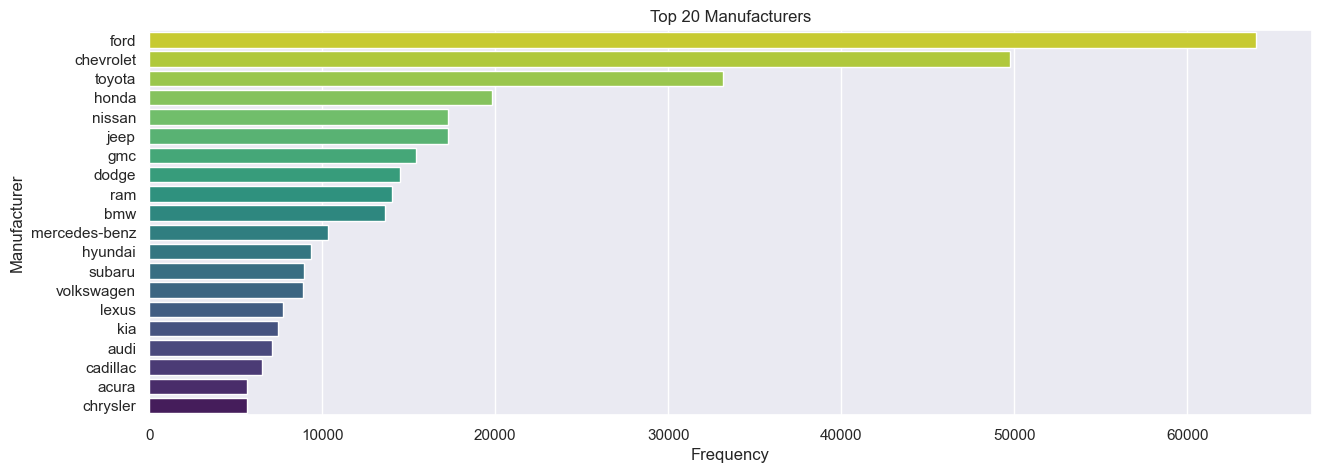

In [39]:
# 가장 많은 빈도수를 가진 20개의 제조업체 바 글래프로 시각화
plt.figure(figsize=(15, 5))

sns.countplot(y='manufacturer', data=vehicle_merged, order=vehicle_merged['manufacturer'].value_counts().iloc[:20].index,
              hue='manufacturer', palette='viridis_r', hue_order=vehicle_merged['manufacturer'].value_counts().iloc[:20].index)

plt.title('Top 20 Manufacturers')
plt.xlabel('Frequency')
plt.ylabel('Manufacturer')
plt.legend([], [], frameon=False)
plt.show()

### 5. 실린더 개수 (Cylinders), 구동방식 (Drive), 차종 (Type)

In [40]:
# 결측치 개수 확인
info.loc[['cylinders', 'drive', 'type'], ['null', 'null_ratio', 'dtype']]

,null,null_ratio,dtype
cylinders,177678,0.416225,object
drive,130567,0.305863,object
type,92858,0.217527,object


이 컬럼들은 결측치가 많으나 (>20%) VIN 데이터로 보완이 가능합니다.

#### i) Cylinders 컬럼
Cylinders 컬럼은 차 내 실린더의 개수를 나타내는 값이기에 숫자형으로 변환할 필요가 있습니다

In [41]:
# Cylinder 컬럼을 숫자형으로 변환  예) 6 cylinders -> 6
vehicle_merged['cylinders'] = vehicle_merged['cylinders'].str.extract('(\d+)').astype('float')

# cylinders로 EngineCylinders 컬럼 결측치 채우기
vehicle_merged['cylinders'] = vehicle_merged['EngineCylinders'].fillna(vehicle_merged['cylinders']).astype('Int8')  # 컬럼 타입을 int8로 변경

vehicle_merged['cylinders'].value_counts()

cylinders
4     117556
6     116513
8      84857
5       2278
3       1536
10      1366
12       246
2        151
1         16
Name: count, dtype: Int64

#### ii) Drive 컬럼

In [42]:
# DriveType, BodyClass 컬럼들을 lowercase로 변경
vehicle_merged[['DriveType', 'BodyClass']] = vehicle_merged[['DriveType', 'BodyClass']].apply(lambda x: x.str.lower())

In [43]:
# Unique 값 확인
print(vehicle_merged['DriveType'].value_counts())
print("\n")
print(vehicle_merged['drive'].value_counts())

DriveType
4wd/4-wheel drive/4x4    73438
4x2                      48583
awd/all-wheel drive      25384
fwd/front-wheel drive    18788
rwd/rear-wheel drive      7352
6x4                        215
not applicable             154
2wd/4wd                     97
8x4                          5
6x6                          1
other                        1
Name: count, dtype: int64


drive
4wd    118975
fwd     96745
rwd     53642
Name: count, dtype: int64


구동 방식의 종류가 VIN 추출 데이터에서 훨씬 많은 것을 볼 수 있는데 좀더 단순화를 시켜 주도록 하겠습니다

4x2 -> 트럭에서 사용하는 2wd와 동일한 구동방식, 트럭에선 주로 rwd를 사용하기 때문에 rwd로 구분하겠습니다\
awd -> 전륜구동, 이륜구동 두가지 방식 다 가능한 차종 (2wd/4wd)랑 동일

나머지 6x4, 8x4, 6x6, other, not applicable은 모두 다 other로 구분하겠습니다.


In [44]:
# DriveType 컬럼 요소를 drive 컬럼 요소로 매핑
drive_mapping = {'4wd/4-wheel drive/4x4': '4wd',
                 '4x2': 'rwd', 'rwd/rear-wheel drive': 'rwd',
                 'awd/all-wheel drive': 'awd', '2wd/4wd': 'awd',
                 'fwd/front-wheel drive': 'fwd',
                 '6x4': 'other', 'not applicable': 'other', '8x4': 'other', '6x6': 'other'}

# DriveType 컬럼 고유 요소 단순화
vehicle_merged['DriveType'] = vehicle_merged['DriveType'].map(drive_mapping)

# drive로 DriveType 컬럼 결측치 채우기
vehicle_merged['drive'] = vehicle_merged['DriveType'].fillna(vehicle_merged['drive'])

vehicle_merged['drive'].value_counts()

drive
4wd      120003
rwd       92223
fwd       76407
awd       25481
other       375
Name: count, dtype: int64

#### iii) Type 컬럼

In [45]:
# VIN의 BodyClass 데이터 고유 값 확인
print(vehicle_merged['BodyClass'].value_counts())
print("\n")
print(vehicle_merged['type'].value_counts())

BodyClass
sport utility vehicle (suv)/multi-purpose vehicle (mpv)                                                          70663
sedan/saloon                                                                                                     58565
pickup                                                                                                           55262
hatchback/liftback/notchback                                                                                     11795
coupe                                                                                                            11604
convertible/cabriolet                                                                                             6137
minivan                                                                                                           5075
crossover utility vehicle (cuv)                                                                                   3790
cargo van                             

이번에도 VIN에서 추출한 데이터의 종류가 더 다양하기 때문에 원래 데이터의 구분 방식으로 매핑해 주겠습니다.

In [46]:
# 세부분류된 차종을 원본 데이터 있는 큰 기준으로 분류하는 딕셔너리 생성
vehicle_mapping = {
    'pickup': [
        'pickup'
    ],
    'truck': [
        'truck', 
        'cargo van', 
        'incomplete - chassis cab (double cab)', 
        'incomplete - chassis cab (single cab)', 
        'incomplete - chassis cab (number of cab unknown)', 
        'truck-tractor'
    ],
    'other': [
        'trailer', 
        'incomplete',
        'incomplete - cutaway',
        'incomplete - motor home chassis',
        'incomplete - stripped chassis',
        'low speed vehicle (lsv) / neighborhood electric vehicle (nev)', 
        'limousine', 
        'fire apparatus', 
        'incomplete - glider', 
        'incomplete - commercial chassis', 
        'motorcycle - cruiser', 
        'motorcycle - sport', 
        'motorcycle - touring / sport touring', 
        'motorcycle - custom', 
        'motorcycle - street', 
        'motorcycle - three-wheeled motorcycle (2 rear wheels)', 
        'motorcycle - unknown body class', 
        'motorcycle - scooter', 
        'motorcycle - standard', 
        'motorcycle - unenclosed three wheeled or open autocycle [1 rear wheel]',
        'motorcycle - moped', 
        'motorcycle - side car', 
        'incomplete - commercial bus chassis', 
        'incomplete - bus chassis', 
        'incomplete - school bus chassis'
    ],
    'coupe': [
        'coupe'
    ],
    'SUV': [
        'sport utility vehicle (suv)/multi-purpose vehicle (mpv)', 
        'crossover utility vehicle (cuv)', 
        'sport utility truck (sut)'
    ],
    'hatchback': [
        'hatchback/liftback/notchback'
    ],
    'mini-van': [
        'minivan'
    ],
    'sedan': [
        'sedan/saloon'
    ],
    'offroad': [
        'off-road vehicle - motocross (off-road short distance, closed track racing)', 
        'off-road vehicle - multipurpose off-highway utility vehicle [mohuv] or recreational off-highway vehicle [rov]'
    ],
    'bus': [
        'bus', 
        'bus - school bus'
    ],
    'convertible': [
        'convertible/cabriolet', 
        'roadster'
    ],
    'wagon': [
        'wagon'
    ],
    'van': [
        'van', 
        'step van / walk-in van'
    ]
}

In [47]:
# BodyClass 컬럼 고유 요소 단순화
vehicle_merged['BodyClass'] = vehicle_merged['BodyClass'].map(lambda x: next((k for k, v in vehicle_mapping.items() if x in v), x))

# drive로 DriveType 컬럼 결측치 채우기
vehicle_merged['type'] = vehicle_merged['BodyClass'].fillna(vehicle_merged['type'])

vehicle_merged['type'].value_counts()

type
SUV            98255
sedan          83901
pickup         63893
truck          18742
coupe          17521
hatchback      15857
convertible     9892
mini-van        7569
wagon           4669
van             3807
other           2730
bus              500
offroad          480
Name: count, dtype: int64

In [48]:
# 사용 완료한 컬럼은 제거
vehicle_merged.drop(['EngineCylinders', 'DriveType', 'BodyClass'], axis=1, inplace=True)

##### b) 모델을 통한 실린더 개수, 구동방식, 그리고 차종 유추

같은 모델의 차량은 실린더 개수, 구동방식, 그리고 차종이 같다는 가정 하에 동일한 모델의 샘플은 같은 값을 채워주겠습니다.

In [49]:
# cylinders, drive, type 컬럼들에 대해 fillna_target 함수 적용
for target in ['cylinders', 'drive', 'type']:
    print(f"-- {target} --")
    vehicle_merged = fillna_target(vehicle_merged, target)

-- cylinders --
추가 보완 전 결측치 개수: 62602개
추가 보완 후 결측치 개수: 7657개
-- drive --
추가 보완 전 결측치 개수: 72632개
추가 보완 후 결측치 개수: 7796개
-- type --
추가 보완 전 결측치 개수: 59305개
추가 보완 후 결측치 개수: 8040개


#### 결측치 변화 시각화
VIN을 이용한 데이터 보완 전과 후의 Manufacturer, Model, Cylinders, Drive, Type 컬럼들의 결측치를 시각화하여 비교해 보겠습니다.

In [50]:
# 보완 전 후 결측치 비율 계산
pre_null_percent = vehicle_data[['manufacturer', 'model', 'cylinders', 'drive', 'type']].isnull().sum() / vehicle_data.shape[0] * 100
post_null_percent = vehicle_merged[['manufacturer', 'model', 'cylinders', 'drive', 'type']].isnull().sum() / vehicle_merged.shape[0] * 100
plot_df = pd.concat([pre_null_percent, post_null_percent], axis=1, keys=['pre_null_percent', 'post_null_percent'])

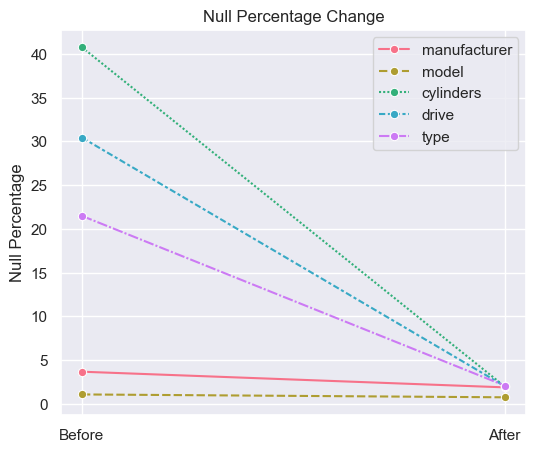

In [51]:
# 보완 전후 결측치 비율 비교 시각화
plt.figure(figsize=(6, 5))

sns.lineplot(data=plot_df[['pre_null_percent', 'post_null_percent']].T, marker='o')

plt.title('Null Percentage Change')
plt.ylabel('Null Percentage')
plt.xticks([0, 1], ['Before', 'After'])

plt.show()

Cylinders, Drive, Type을 결측치가 확연히 감소한 것을 볼 수 있습니다.

### 6. 연료 (fuel), 기어 (transmission)

In [52]:
# 결측치 개수 확인
info.loc[['fuel', 'transmission'], ['null', 'null_ratio', 'dtype']]

,null,null_ratio,dtype
fuel,3013,0.007058,object
transmission,2556,0.005988,object


위 컬럼들은 VIN으로 보충해 줄 수 있는 데이터지만 결측치의 비율이 매우 낮기 때문에 (1% 이하) 별도의 전처리 과정 없이 진행하겠습니다. 

In [53]:
# 필요없는 컬럼들 제거
vehicle_merged.drop(['FuelTypePrimary', 'TransmissionStyle'], axis=1, inplace=True)

### 7. 차량 타이틀 (title_status)
자동차의 소유권이 누구에게 있는지를 의미하는 레이블입니다. 또한 차량이 사고로 인해 폐차 후 재정비된 적 있는지에 대한 정보도 나와있습니다.

In [54]:
# 고유 값의 빈도율 확인
round(vehicle_merged['title_status'].value_counts() / vehicle_merged.shape[0] * 100, 2)

title_status
clean         94.74
rebuilt        1.80
salvage        0.98
lien           0.36
missing        0.15
parts only     0.04
Name: count, dtype: float64

고유값들을 봤을 때 94.7%의 값들이 clean인 것을 볼 수 있습니다. 이렇게 다양성이 적은 컬럼은 딱히 돋움이 되지 못할 것 같아 제거하겠습니다.

In [55]:
vehicle_merged.drop('title_status', axis=1, inplace=True)

### 8. 주행거리계 (odometer)
주행거리계에 있는 수치로, 차가 달린 mile을 표시합니다.

In [56]:
# 결측치 개수 확인
info.loc[['odometer'], ['null', 'null_ratio', 'dtype']]

,null,null_ratio,dtype
odometer,4400,0.010307,float64


결측치 비율도 낮고 숫자형 dtype으로 정확히 들어있는 것을 볼 수 있습니다.

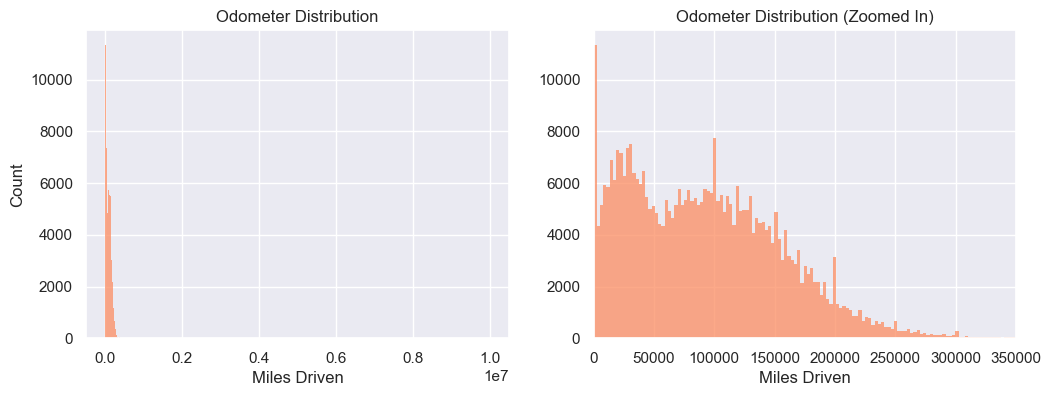

In [57]:
# Odometer 컬럼 분포 시각화
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

# histplot 그리기
sns.histplot(vehicle_merged['odometer'], ax=axis[0])
axis[0].set_title('Odometer Distribution')
axis[0].set_xlabel('Miles Driven')

# x축의 범위를 지정하여 histplot 그리기
sns.histplot(vehicle_merged['odometer'], ax=axis[1])
axis[1].set_title('Odometer Distribution (Zoomed In)')
axis[1].set_xlabel('Miles Driven')
axis[1].set_xlim(0, 350000)
axis[1].set_ylabel('')

plt.show()

엄청 높은 이상치들이 있는 것을 볼 수 있습니다.

데이터의 분포가 정규분포가 아니기에 IQR값을 이용해서 이상치를 분류해 주겠습니다.

In [58]:
# IQR을 이용한 이상치 제거
Q1 = vehicle_merged['odometer'].quantile(0.25)
Q3 = vehicle_merged['odometer'].quantile(0.75)
IQR = Q3 - Q1

# Q1 / Q3에서 1.5 * IQR 이상 벗어난 값 제거
vehicle_filtered = vehicle_merged[(vehicle_merged['odometer'] >= Q1 - 1.5 * IQR) & (vehicle_merged['odometer'] <= Q3 + 1.5 * IQR)]

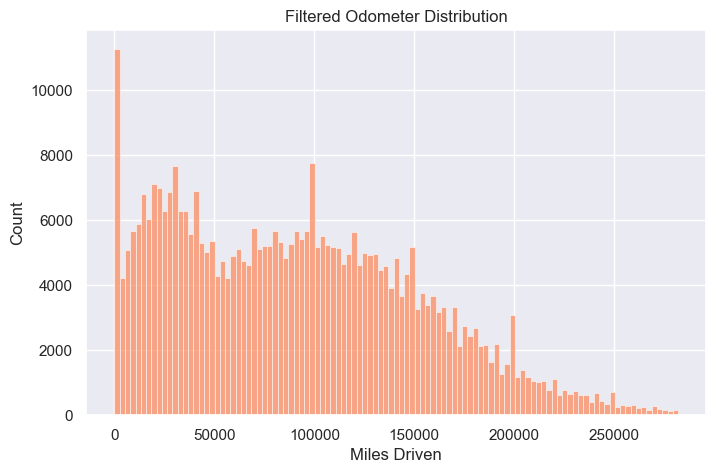

In [59]:
# 이상치를 제거한 분포도 그리기
plt.figure(figsize=(8, 5))
sns.histplot(vehicle_filtered['odometer'])
plt.title('Filtered Odometer Distribution')
plt.xlabel('Miles Driven')

plt.show()

### 9. 지역(region), 주(state), 위도(latitude), 경도(longitude)
Craigslist는 지역 별로 웹사이트가 나눠져 있습니다.\
위 정보는 어느 지역에 해당 중고차 매매 공고가 올라갔는지 표시하는 지리적 데이터입니다.

In [60]:
# 결측치 개수 확인
info.loc[['region', 'state', 'lat', 'long'], ['null', 'null_ratio', 'dtype']]

,null,null_ratio,dtype
region,0,0.000000,object
state,0,0.000000,object
lat,6549,0.015342,float64
long,6549,0.015342,float64


### 10. 기타 미사용 변수

#### i) 설명 (description)

In [ ]:
# 결측치 개수 확인
info.loc['description', ['null', 'null_ratio', 'dtype']]

null                70
null_ratio    0.000164
dtype           object
Name: description, dtype: object

설명 컬럼은 LDA 토픽 모델링을 사용하여 각 샘플마다 토픽을 분류해 주었습니다.

해당 코드는 너무 길어 별도의 description_lda.ipynb 안에 명시되어 있습니다.

In [ ]:
# 토픽 모델링을 완료한 description 데이터 불러오기
# description_lda = pd.read_parquet('description_lda.parquet')

Description의 텍스트 전처리 과정이 길고 안에서 유의미한 토픽 모델링을 진행하지 못하여 배제하고 진행하겠습니다.\
*(차후 연구에 다시 고려해 볼 수 있는 부분)*

In [ ]:
vehicle_filtered.drop('description', axis=1, inplace=True)

#### ii) 상태 (Condition), 크기 (Size), 색깔 (Paint Color) 

In [65]:
# 결측치 개수 확인
info.loc[['condition', 'size', 'paint_color'], ['null', 'null_ratio', 'dtype']]

,null,null_ratio,dtype
condition,174104,0.407852,object
size,306361,0.717675,object
paint_color,130203,0.305011,object


해당 컬럼들은 결측치가 30% 이상이고 다른 데이터로 보완이 어려운 컬럼들이기에 제외하겠습니다.

#### iii) 글 쓴 날짜 (Posting date)
모든 데이터는 2021-04-04 부터 2021-05-05 사이에 Cragislist에 올라온 데이터입니다.\
해당 컬럼은 중고차 값에 큰 영향을 미치지 않을 것으로 간주하여 제외하겠습니다.

In [66]:
# 필요없는 컬럼들 제거
vehicle_filtered.drop(['condition', 'size', 'paint_color', 'posting_date'], axis=1, inplace=True)

---
### 추가 고려사항

차량마다 VIN (차대번호)는 달라야하는데 동일한 VIN을 가진 샘플이 여럿 있습니다.

이는 하나의 차를 여러 공고에 올린 것(다른 지역)을 의미합니다.

In [78]:
n_duplicate_VIN = (vehicle_filtered.groupby('VIN')['VIN'].value_counts() > 1).sum()
print(f"중복되는 VIN 개수: {n_duplicate_VIN}")

중복되는 VIN 개수: 35259


In [84]:
# VIN 번호가 중복되는 데이터 제거 (VIN이 결측치인 데이터는 포함하지 않음)
temp = vehicle_filtered[vehicle_filtered['VIN'].notnull()].drop_duplicates(subset='VIN', keep='first')

vehicle_dropped = pd.concat([temp, vehicle_filtered[vehicle_filtered['VIN'].isnull()]], axis=0)

print(f"제거된 중복 데이터 개수: {vehicle_filtered.shape[0] - vehicle_dropped.shape[0]}개")

제거된 중복 데이터 개수: 133171개


In [93]:
# 같은 VIN을 갖고 있는 차량 중 지역이 다른 차량이 있는지 확인
n_different_price = (vehicle_filtered.groupby('VIN')['region'].nunique() > 1).sum()
print(f"동일한 VIN이지만 판매 지역이 다른 차량 개수: {n_different_price}")

# 같은 VIN을 갖고 있는 차량 중 가격이 다른 차량이 있는지 확인
n_different_price = (vehicle_filtered.groupby('VIN')['price'].nunique() > 1).sum()
print(f"동일한 VIN이지만 제시 가격이 다른 차량 개수: {n_different_price}")

동일한 VIN이지만 판매 지역이 다른 차량 개수: 23770
동일한 VIN이지만 제시 가격이 다른 차량 개수: 2731


이번 연구에선 차후에 지역별 특성도 적용하여 가격에 미치는 영향을 보고 싶기에 차량 VIN 같은 샘플이라도 제거해 주진 않았습니다.\
(같은 차라도 다른 지역에서 팔 경우 가격이 다를 수 있기 때문)

### 차대번호 (VIN)
데이터 추출을 완료한 VIN 컬럼도 제거해 주겠습니다

In [69]:
vehicle_final = vehicle_filtered.drop(['VIN'], axis=1)

---
## 전처리 완료된 데이터의 결측치 개수 확인

In [70]:
n_info = vehicle_final.agg(['nunique', 'count', 'size']).T
n_info['null'] = vehicle_final.isnull().sum()
n_info['null_pct'] = n_info['null'] / n_info['size']
n_info['dtypes'] = vehicle_final.dtypes
n_info

,nunique,count,size,null,null_pct,dtypes
region,404,381255,381255,0,0.000000,object
price,15355,381255,381255,0,0.000000,int64
model_year,63,381255,381255,0,0.000000,Int64
manufacturer,71,374659,381255,6596,0.017301,object
model,15317,378509,381255,2746,0.007203,object
cylinders,9,374051,381255,7204,0.018895,Int8
fuel,5,379137,381255,2118,0.005555,object
odometer,96666,381255,381255,0,0.000000,float64
transmission,3,379750,381255,1505,0.003947,object
drive,5,373926,381255,7329,0.019223,object


In [71]:
# 아직도 결측치가 있는 행은 제거
print(f"결측치 제거 전 샘플 수: {len(vehicle_final)}")
print(f"결측치 제거 시 남는 샘플 수: {len(vehicle_final.dropna())}")
print(f"제거되는 샘플 비율: {1 - len(vehicle_final.dropna()) / len(vehicle_final):.2%}")

결측치 제거 전 샘플 수: 381255
결측치 제거 시 남는 샘플 수: 358991
제거되는 샘플 비율: 5.84%


In [72]:
vehicle_final.dropna(inplace=True)

---

## 범주형 변수 분포 시각화

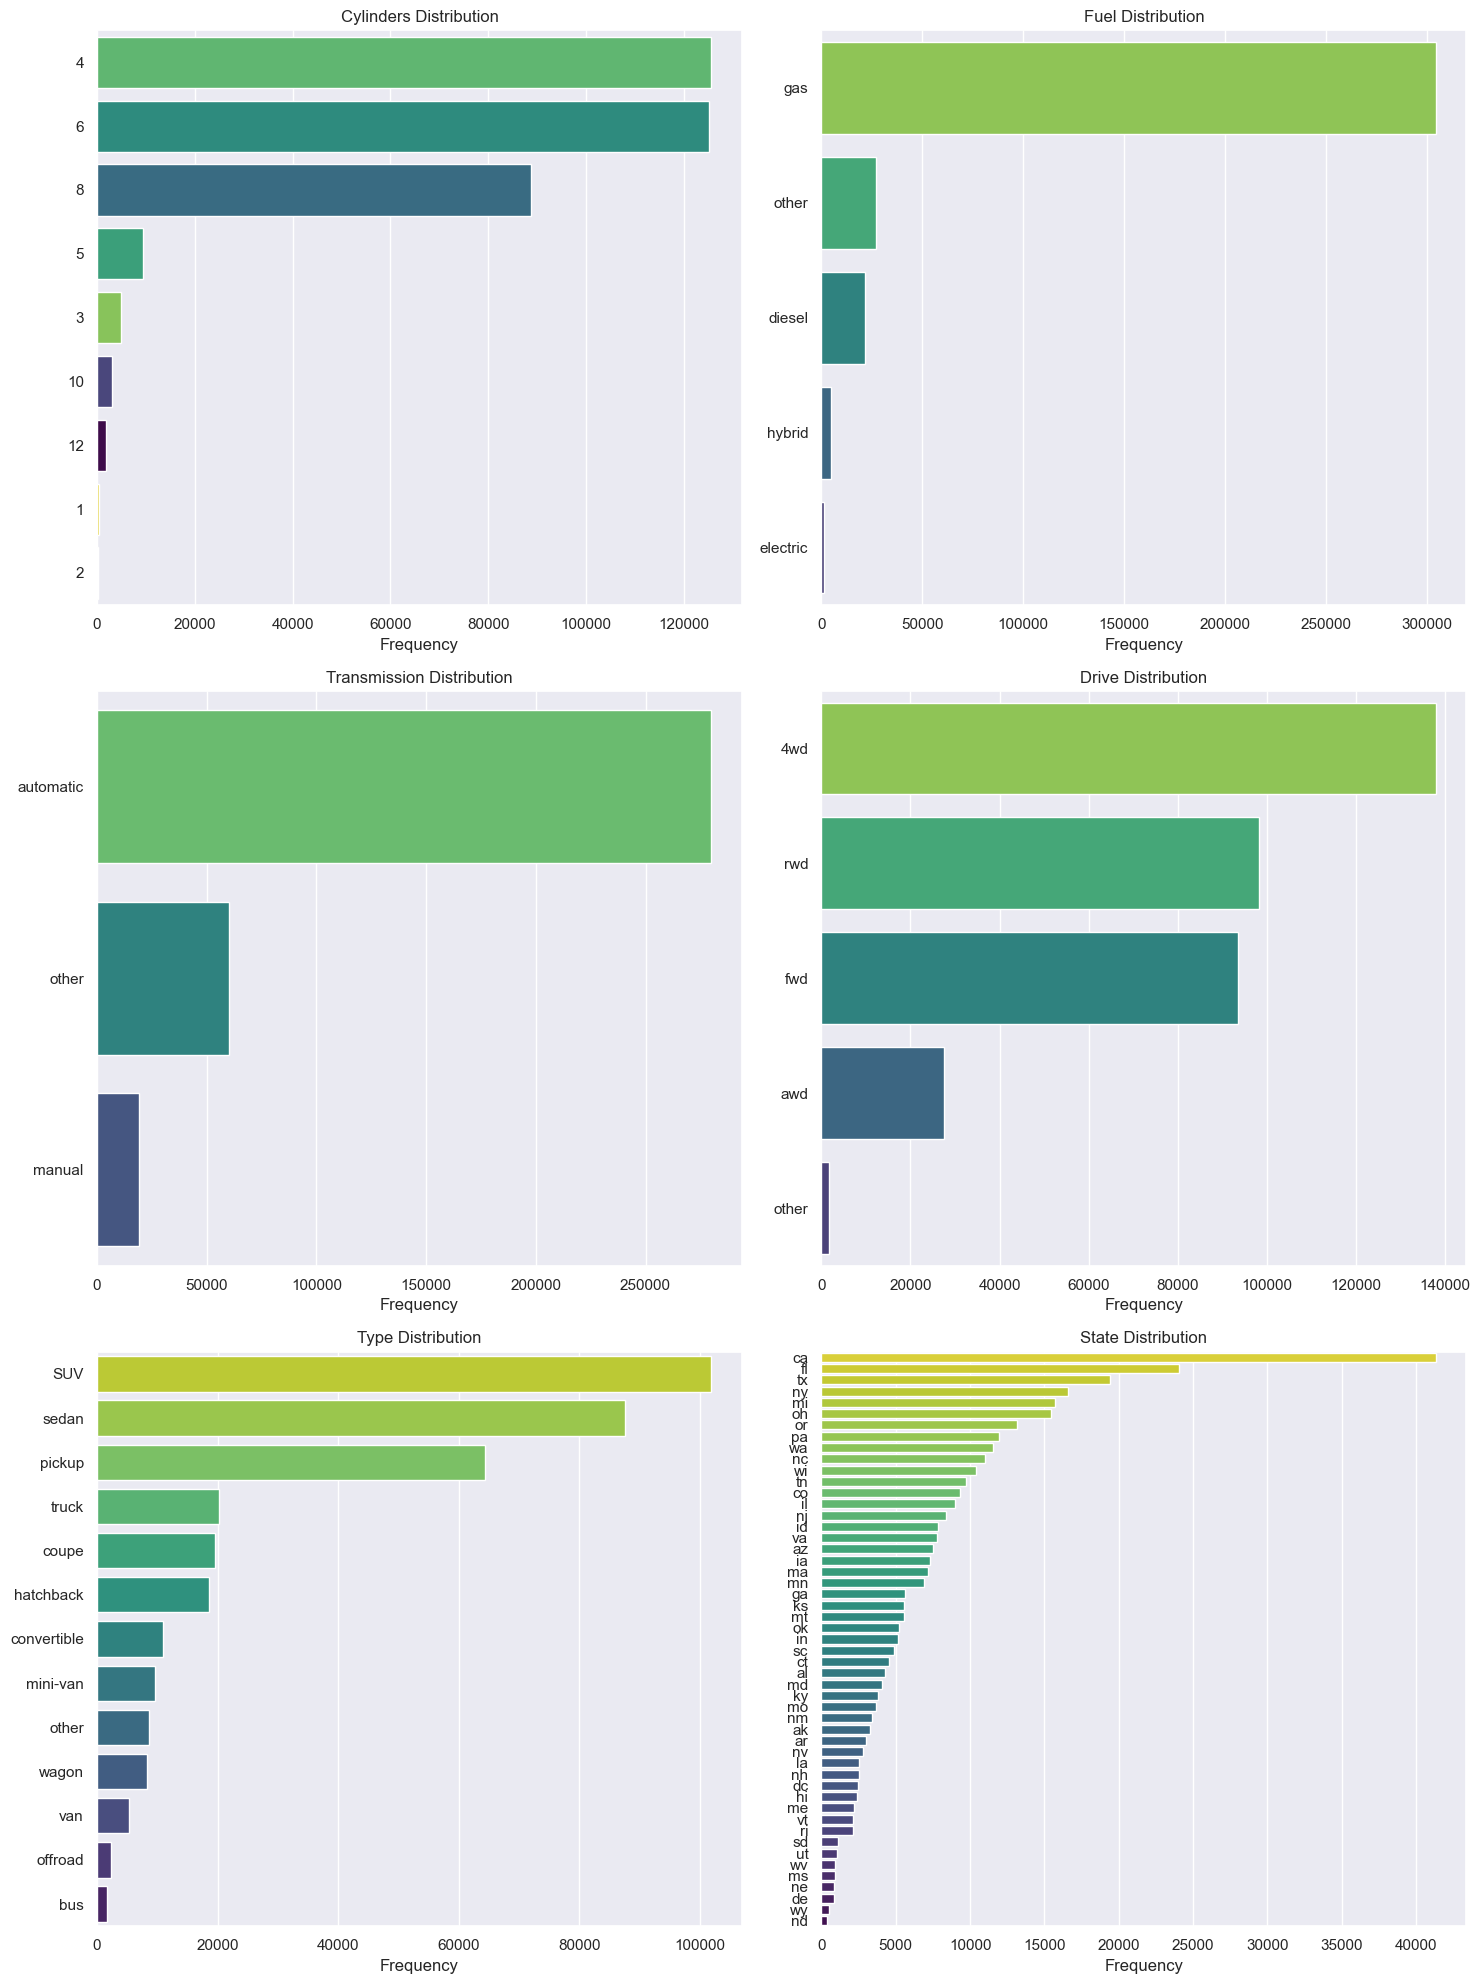

In [73]:
# 범주형 컬럼 리스트 생성
categorical_columns = ['cylinders', 'fuel', 'transmission', 'drive', 'type', 'state']

# 범주형 컬럼 데이터 타입 변경
vehicles_categorical = vehicle_final[categorical_columns].astype('object')
vehicles_categorical.fillna('Unknown', inplace=True)

# 범주형 컬럼 시각화
fig, axis = plt.subplots(3, 2, figsize=(15, 20))

for i, column in enumerate(categorical_columns):
    sns.countplot(y=column, data=vehicles_categorical, ax=axis[i // 2, i % 2], order=vehicle_final[column].value_counts().index,
                  hue=column, palette='viridis_r', hue_order=vehicle_final[column].value_counts().index)
    
    axis[i // 2, i % 2].set_title(f'{column.capitalize()} Distribution')
    axis[i // 2, i % 2].set_ylabel('')
    axis[i // 2, i % 2].set_xlabel('Frequency')
    
    # 범례 삭제
    try:
        axis[i // 2, i % 2].get_legend().remove()
    except:
        pass

plt.tight_layout()
plt.show()

## Cylinder 개수에 따른 가격 평균 계산

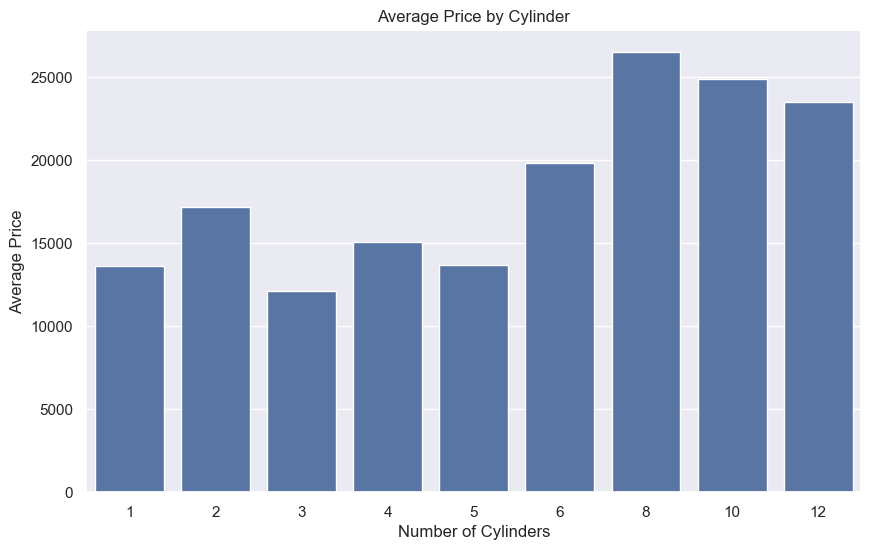

In [ ]:
# Cylinder 개수에 따른 가격 평균 계산
avg_price = vehicle_final.groupby('cylinders')['price'].mean()

# Cylinder 대 average Price 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='cylinders', y='price', data=pd.DataFrame(avg_price))
plt.title('Average Price by Cylinder')
plt.ylabel('Average Price')
plt.xlabel('Number of Cylinders')
plt.show()

실린더 개수가 많은 차들이(6 실린더 이상) 대체적으로 더 높은 평균 가격을 가지는 것을 볼 수 있습니다.

---
### 전처리 완료 데이터 저장

In [94]:
vehicle_final.to_parquet('./data/vehicle_preprocessed.parquet', index=False)

---
---